# Day 2  进阶作业-HH model
Please follow the comment instruction to fill the *todo* blanks of the following code. Then run all the cells to see the simulation result.

In [ ]:
import brainpy as bp
import brainpy.math as bm

In [ ]:
class IK(bp.dyn.IonChannel):
  def __init__(self, size, E=-77., g_max=36., phi=1., method='exp_auto'):
    super(IK, self).__init__(size)
    self.g_max = g_max
    self.E = E
    self.phi = phi

    # TODO: 初始化门控变量self.n：统一设置为0，动态变量大小为size
    self.n = ... 
    
    self.integral = bp.odeint(self.dn, method=method)

  def dn(self, n, t, V):
    # TODO: 计算dn/dt
    return dndt

  def update(self, V):
    t = bp.share.load('t')
    dt = bp.share.load('dt')
    # TODO: 更新self.n
    self.n.value = ...

  def current(self, V):
    return self.g_max * self.n ** 4 * (self.E - V)

In [ ]:
class INa(bp.dyn.IonChannel):
  def __init__(self, size, E= 50., g_max=120., phi=1., method='exp_auto'):
    super(INa, self).__init__(size)
    self.g_max = g_max
    self.E = E
    self.phi = phi

     # TODO: 初始化门控变量self.m, self.h：统一设置为0，动态变量大小为size
    self.m = ...
    self.h = ...
    
    self.integral_m = bp.odeint(self.dm, method=method)
    self.integral_h = bp.odeint(self.dh, method=method)

  def dm(self, m, t, V):
    # TODO: 计算dm/dt
    return dmdt

  def dh(self, h, t, V):
    # TODO: 计算dh/dt
    return dhdt

  def update(self, V):
    t = bp.share.load('t')
    dt = bp.share.load('dt')
    # TODO: 更新self.m, self.h
    self.m.value = ...
    self.h.value = ...

  def current(self, V):
    return self.g_max * self.m ** 3 * self.h * (self.E - V)

In [ ]:
class IL(bp.dyn.IonChannel):
  def __init__(self, size, E=-54.39, g_max=0.03):
    super(IL, self).__init__(size)
    self.g_max = g_max
    self.E = E

  def current(self, V):
    return self.g_max * (self.E - V)
  def update(self, V):
    pass

In [ ]:
class HH(bp.dyn.CondNeuGroup):
  def __init__(self, size):
    super(HH, self).__init__(size, V_initializer=bp.init.Uniform(-80, -60.))
    # TODO: 初始化三个离子通道
    self.IK = ... # 参数：E=-77., g_max=36.
    self.INa = ... # 参数：E=50., g_max=120.
    self.IL = ... # 参数：E=-54.39, g_max=0.03

In [ ]:
neu = HH(1)

runner = bp.DSRunner(
    neu, 
    monitors=['V', 'IK.n', 'INa.m', 'INa.h'], 
    inputs=('input', 1.698)  # near the threshold current
)

runner.run(200)  # the running time is 200 ms

import matplotlib.pyplot as plt

plt.plot(runner.mon['ts'], runner.mon['V'])
plt.xlabel('t (ms)')
plt.ylabel('V (mV)')
plt.savefig("HH.jpg")
plt.show()

plt.figure(figsize=(6, 2))
plt.plot(runner.mon['ts'], runner.mon['IK.n'], label='n')
plt.plot(runner.mon['ts'], runner.mon['INa.m'], label='m')
plt.plot(runner.mon['ts'], runner.mon['INa.h'], label='h')
plt.xlabel('t (ms)')
plt.legend()
plt.savefig("HH_channels.jpg")

plt.show()

## Answer

  0%|          | 0/2000 [00:00<?, ?it/s]

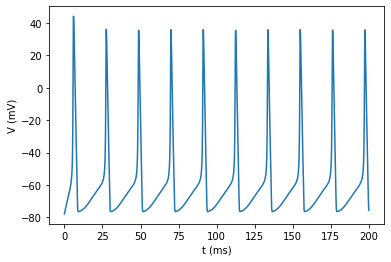

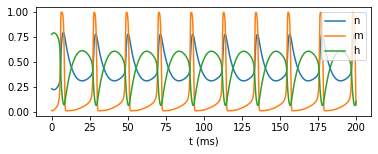

In [116]:
import brainpy as bp
import brainpy.math as bm

class IK(bp.dyn.IonChannel):
  def __init__(self, size, E=-77., g_max=36., phi=1., method='exp_auto'):
    super(IK, self).__init__(size)
    self.g_max = g_max
    self.E = E
    self.phi = phi

    self.n = bm.Variable(0.235 * bm.ones(self.num))
    
    self.integral = bp.odeint(self.dn, method=method)

  def dn(self, n, t, V):
    alpha_n = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta_n = 0.125 * bm.exp(-(V + 65) / 80)
    return self.phi * (alpha_n * (1. - n) - beta_n * n)

  def update(self, V):
    t = bp.share.load('t')
    dt = bp.share.load('dt')
    self.n.value = self.integral(self.n, t, V, dt=dt)

  def current(self, V):
    return self.g_max * self.n ** 4 * (self.E - V)
  
class INa(bp.dyn.IonChannel):
  def __init__(self, size, E= 50., g_max=120., phi=1., method='exp_auto'):
    super(INa, self).__init__(size)
    self.g_max = g_max
    self.E = E
    self.phi = phi

    self.m = bm.Variable(0.0266 * bm.ones(self.size))
    self.h = bm.Variable(0.772 * bm.ones(self.size))
    
    self.integral_m = bp.odeint(self.dm, method=method)
    self.integral_h = bp.odeint(self.dh, method=method)


  def dm(self, m, t, V):
    alpha_m = 0.1 * (V + 40) / (1 - bm.exp (-(V + 40) / 10))
    beta_m = 4* bm.exp(-(V + 65) /18)
    return self.phi * (alpha_m * (1. - m) - beta_m * m)
  def dh(self, h, t, V):
    alpha_h = 0.07 * bm.exp(-(V + 65) / 20)
    beta_h = 1. / (1 + bm.exp(-(V + 35) / 10))
    return self.phi * (alpha_h * (1. - h) - beta_h * h)

  def update(self, V):
    t = bp.share.load('t')
    dt = bp.share.load('dt')
    self.m.value = self.integral_m(self.m, t, V, dt=dt)
    self.h.value = self.integral_h(self.h, t, V, dt=dt)

  def current(self, V):
    return self.g_max * self.m ** 3 * self.h * (self.E - V)
  
class IL(bp.dyn.IonChannel):
  def __init__(self, size, E=-54.39, g_max=0.03):
    super(IL, self).__init__(size)
    self.g_max = g_max
    self.E = E

  def current(self, V):
    return self.g_max * (self.E - V)
  def update(self, V):
    pass
  
class HH(bp.dyn.CondNeuGroup):
  def __init__(self, size):
    super(HH, self).__init__(size, V_initializer=bp.init.Uniform(-80, -70.))
    self.IK = IK(size, E=-77., g_max=36.)
    self.INa = INa(size, E=50., g_max=120.)
    self.IL = IL(size, E=-54.39, g_max=0.03)
neu = HH(1)

runner = bp.DSRunner(
    neu, 
    monitors=['V', 'IK.n', 'INa.m', 'INa.h'], 
    inputs=('input', 4.0)  # near the threshold current
)

runner.run(200)  # the running time is 200 ms

import matplotlib.pyplot as plt

plt.plot(runner.mon['ts'], runner.mon['V'])
plt.xlabel('t (ms)')
plt.ylabel('V (mV)')
plt.savefig("HH.jpg")
plt.show()

plt.figure(figsize=(6, 2))
plt.plot(runner.mon['ts'], runner.mon['IK.n'], label='n')
plt.plot(runner.mon['ts'], runner.mon['INa.m'], label='m')
plt.plot(runner.mon['ts'], runner.mon['INa.h'], label='h')
plt.xlabel('t (ms)')
plt.legend()
plt.savefig("HH_channels.jpg")

plt.show()